# Time Series Forecasting with LSTM: Air Passengers Dataset

This notebook demonstrates time series forecasting using an LSTM neural network on the classic [Air Passengers dataset](https://www.kaggle.com/datasets/andreazzini/international-airline-passengers).

- The dataset contains monthly totals of international airline passengers from 1949 to 1960.
- It is a standard benchmark for time series forecasting.
- The dataset is small enough for fast experimentation but large enough to demonstrate LSTM forecasting.

In [10]:


pip install seaborn

     -------------------------------------- 294.9/294.9 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
pip install xgboost

     -------------------------------------- 150.0/150.0 MB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
EPOCHS = 5000  # You can increase for better LSTM performance


In [27]:
print("Loading data...")
df = pd.read_csv(r"C:\Users\RISHAB ARYA\Downloads\data\daily.csv")
df.columns = ['datetime', 'temp']
df['temp'] = pd.to_numeric(df['temp'], errors='coerce')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna()
print(f"Dataset shape: {df.shape}")
df.head()


Loading data...
Dataset shape: (3647, 2)


,datetime,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [28]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['dayofyear'] = df['datetime'].dt.dayofyear
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek

# Lag features
for lag in [1, 2, 3, 7]:
    df[f'temp_lag_{lag}'] = df['temp'].shift(lag)

# Rolling features
for window in [3, 7, 14]:
    df[f'temp_rolling_mean_{window}'] = df['temp'].rolling(window).mean()
    df[f'temp_rolling_std_{window}'] = df['temp'].rolling(window).std()

df = df.dropna()
df.head()


,datetime,temp,year,month,dayofyear,hour,dayofweek,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_7,temp_rolling_mean_3,temp_rolling_std_3,temp_rolling_mean_7,temp_rolling_std_7,temp_rolling_mean_14,temp_rolling_std_14
13,1981-01-14,21.5,1981,1,14,0,2,16.7,13.3,16.2,15.8,17.166667,4.119871,18.128571,3.107901,17.592857,2.627799
14,1981-01-15,25.0,1981,1,15,0,3,21.5,16.7,13.3,17.4,21.066667,4.166933,19.214286,4.008087,17.900000,3.206484
15,1981-01-16,20.7,1981,1,16,0,4,25.0,21.5,16.7,21.8,22.400000,2.286919,19.057143,3.910182,18.100000,3.292649
16,1981-01-17,20.6,1981,1,17,0,5,20.7,25.0,21.5,20.0,22.100000,2.511971,19.142857,3.940752,18.228571,3.356607
17,1981-01-18,24.8,1981,1,18,0,6,20.6,20.7,25.0,16.2,22.033333,2.396525,20.371429,4.202267,18.957143,3.606130


In [29]:
X = df.drop(columns=['temp', 'datetime'])
y = df['temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)


In [31]:
def print_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Explained Variance: {evs:.4f}")

print("XGBoost Performance:")
print_metrics(y_test, y_pred_xgb)


XGBoost Performance:
RMSE: 0.5388
MAE: 0.3873
R²: 0.9827
Explained Variance: 0.9827


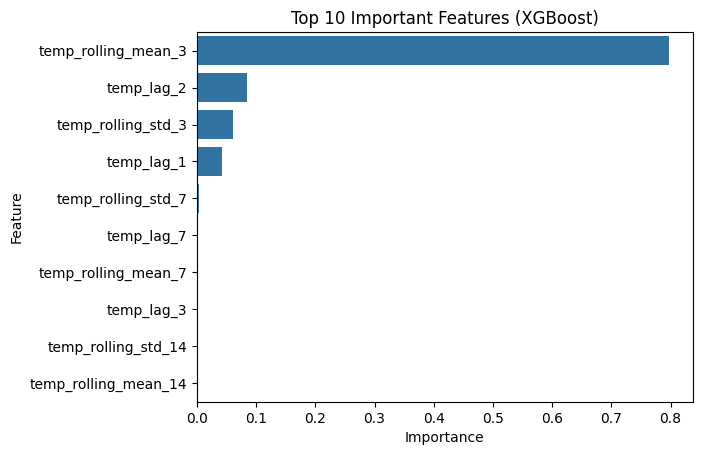

In [32]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features (XGBoost)')
plt.show()


In [33]:
def create_sequences(data, targets, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(targets[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X_seq, y_seq = create_sequences(X.values, y.values, seq_length)

train_size = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]

scaler_lstm = MinMaxScaler()
X_train_seq = np.array([scaler_lstm.fit_transform(x) for x in X_train_seq])
X_test_seq = np.array([scaler_lstm.transform(x) for x in X_test_seq])


In [34]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)


Epoch 1/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 86.7502 - val_loss: 69.8597
Epoch 2/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.1561 - val_loss: 64.1910
Epoch 3/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.9108 - val_loss: 62.8273
Epoch 4/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.9448 - val_loss: 62.5354
Epoch 5/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 18.0062 - val_loss: 62.3749
Epoch 6/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.7488 - val_loss: 62.1690
Epoch 7/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 18.2988 - val_loss: 62.0940
Epoch 8/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.9496 - val_loss: 61.7922
Epoch 9/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.8868 - val_loss: 61.6240
Epoch 10/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.8011 - val_loss: 61.6080
Epoch 11/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 18.2465 - val_loss: 61.3589
Epoch 12/5000
91/91 ━━━━━━

In [35]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)


Epoch 1/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 80.5491 - val_loss: 70.4596
Epoch 2/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.7846 - val_loss: 64.5117
Epoch 3/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.3265 - val_loss: 62.7937
Epoch 4/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.6734 - val_loss: 62.4802
Epoch 5/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 17.8912 - val_loss: 62.2160
Epoch 6/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.3599 - val_loss: 62.1093
Epoch 7/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.2555 - val_loss: 61.8940
Epoch 8/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.2546 - val_loss: 61.8213
Epoch 9/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.9610 - val_loss: 61.6006
Epoch 10/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.1463 - val_loss: 61.4110
Epoch 11/5000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.9469 - val_loss: 61.1161
Epoch 12/5000
91/91 ━━━━━━━━━━

In [36]:
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()

print("LSTM Performance:")
print_metrics(y_test_seq, y_pred_lstm)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM Performance:
RMSE: 3.5052
MAE: 2.8425
R²: 0.2672
Explained Variance: 0.3971


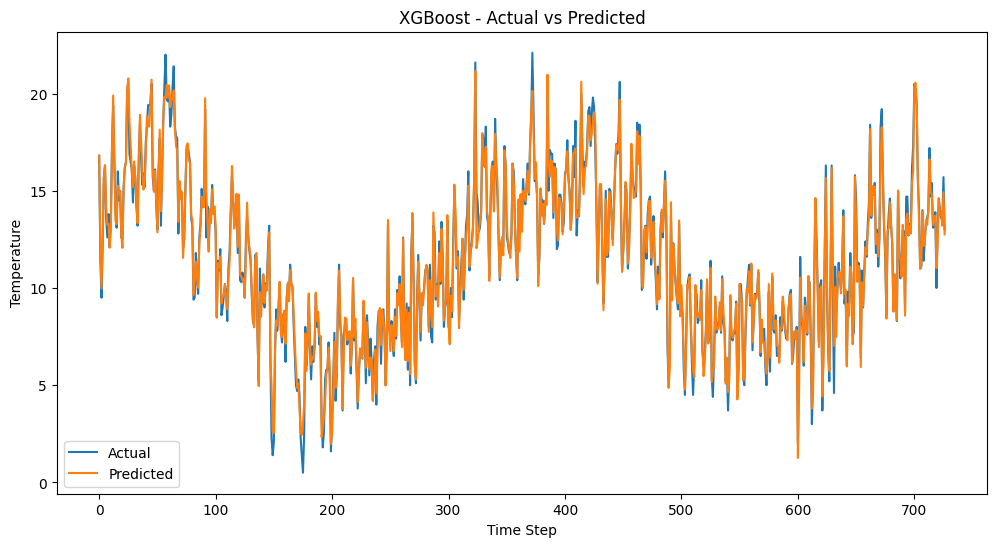

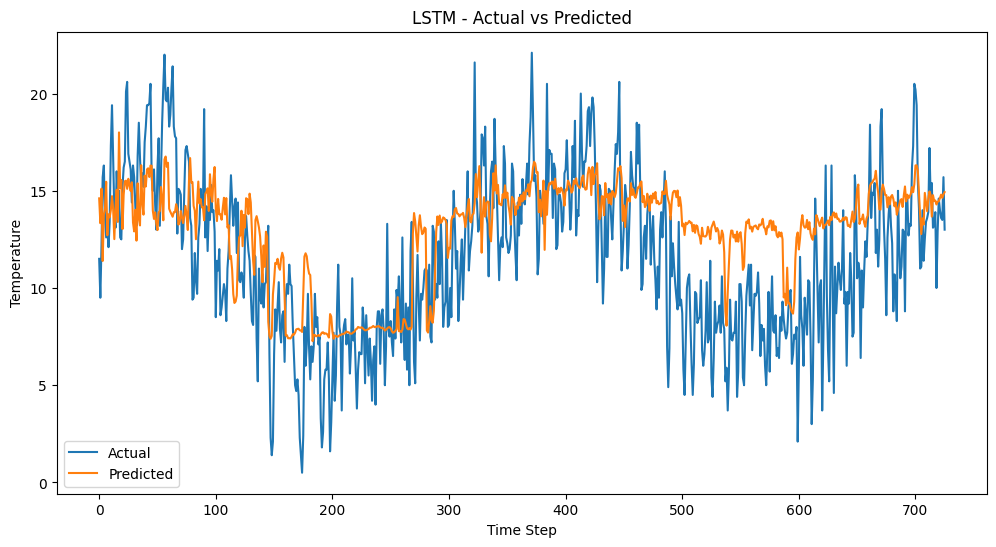

In [37]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true.values if hasattr(y_true, 'values') else y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

plot_predictions(y_test, y_pred_xgb, 'XGBoost')
plot_predictions(y_test_seq, y_pred_lstm, 'LSTM')


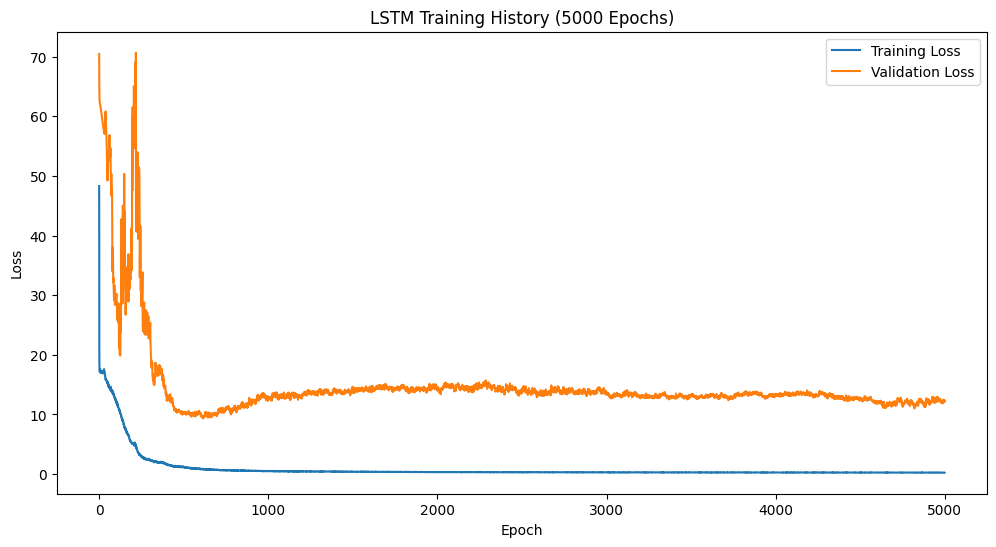

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'LSTM Training History ({EPOCHS} Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
